In [1]:
import pymc3 as pm
import pandas as pd
from yyyy_mm_dd import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("forecasts.csv", parse_dates=['timestamp'])
df

,timestamp,type,forecast_delta,city,summary,precipitation,temperature,max,min
0,2021-04-26 07:40:55.852295,daily,0,Amsterdam,Partly Cloudy,1,NaN,11.0,2.0
1,2021-04-26 07:40:55.852295,daily,1,Amsterdam,Partly Cloudy,8,NaN,15.0,4.0
2,2021-04-26 07:40:55.852295,daily,2,Amsterdam,Mostly Sunny,5,NaN,16.0,6.0
3,2021-04-26 07:40:55.852295,daily,3,Amsterdam,Light Rain,82,NaN,11.0,5.0
4,2021-04-26 07:40:55.852295,daily,4,Amsterdam,Showers,47,NaN,12.0,4.0
...,...,...,...,...,...,...,...,...,...
123727,2021-05-09 20:00:41.644181,hourly,43,Cairo,Sunny,0,33.0,NaN,NaN
123728,2021-05-09 20:00:41.644181,hourly,44,Cairo,Sunny,0,32.0,NaN,NaN
123729,2021-05-09 20:00:41.644181,hourly,45,Cairo,Clear,0,29.0,NaN,NaN
123730,2021-05-09 20:00:41.644181,hourly,46,Cairo,Clear,0,28.0,NaN,NaN


In [3]:
hourly = df[df.type == 'hourly'].copy().reset_index()
hourly = hourly.drop(columns=['min', 'max'])
hourly['precipitation'] /= 100
hourly

,index,timestamp,type,forecast_delta,city,summary,precipitation,temperature
0,15,2021-04-26 07:40:57.075596,hourly,1,Amsterdam,Partly Cloudy,0.01,8.0
1,16,2021-04-26 07:40:57.075596,hourly,2,Amsterdam,Partly Cloudy,0.00,9.0
2,17,2021-04-26 07:40:57.075596,hourly,3,Amsterdam,Mostly Sunny,0.00,9.0
3,18,2021-04-26 07:40:57.075596,hourly,4,Amsterdam,Mostly Sunny,0.00,9.0
4,19,2021-04-26 07:40:57.075596,hourly,5,Amsterdam,Sunny,0.00,10.0
...,...,...,...,...,...,...,...,...
94267,123727,2021-05-09 20:00:41.644181,hourly,43,Cairo,Sunny,0.00,33.0
94268,123728,2021-05-09 20:00:41.644181,hourly,44,Cairo,Sunny,0.00,32.0
94269,123729,2021-05-09 20:00:41.644181,hourly,45,Cairo,Clear,0.00,29.0
94270,123730,2021-05-09 20:00:41.644181,hourly,46,Cairo,Clear,0.00,28.0


In [4]:
hourly['timestamp'] = [ start_of_yyyy_mm_dd_hh(timestamp) for timestamp in hourly['timestamp'] ]
hourly['forecast_for'] = [ move_yyyy_mm_dd_hh(timestamp, delta)
                           for timestamp, delta in zip(hourly['timestamp'], hourly['forecast_delta']) ]
hourly

,index,timestamp,type,forecast_delta,city,summary,precipitation,temperature,forecast_for
0,15,2021-04-26 07:00:00,hourly,1,Amsterdam,Partly Cloudy,0.01,8.0,2021-04-26 08:00:00
1,16,2021-04-26 07:00:00,hourly,2,Amsterdam,Partly Cloudy,0.00,9.0,2021-04-26 09:00:00
2,17,2021-04-26 07:00:00,hourly,3,Amsterdam,Mostly Sunny,0.00,9.0,2021-04-26 10:00:00
3,18,2021-04-26 07:00:00,hourly,4,Amsterdam,Mostly Sunny,0.00,9.0,2021-04-26 11:00:00
4,19,2021-04-26 07:00:00,hourly,5,Amsterdam,Sunny,0.00,10.0,2021-04-26 12:00:00
...,...,...,...,...,...,...,...,...,...
94267,123727,2021-05-09 20:00:00,hourly,43,Cairo,Sunny,0.00,33.0,2021-05-11 15:00:00
94268,123728,2021-05-09 20:00:00,hourly,44,Cairo,Sunny,0.00,32.0,2021-05-11 16:00:00
94269,123729,2021-05-09 20:00:00,hourly,45,Cairo,Clear,0.00,29.0,2021-05-11 17:00:00
94270,123730,2021-05-09 20:00:00,hourly,46,Cairo,Clear,0.00,28.0,2021-05-11 18:00:00


In [5]:
to_join = hourly[hourly.forecast_delta == 0].drop(columns=['forecast_for']).rename(columns={'timestamp': 'forecast_for'}).set_index(['city', 'forecast_for'])[['precipitation']].copy()
hourly = hourly.join(
    to_join,
    on=['city', 'forecast_for'],
    how='inner',
    rsuffix="_actual"
)
hourly

,index,timestamp,type,forecast_delta,city,summary,precipitation,temperature,forecast_for,precipitation_actual
1,16,2021-04-26 07:00:00,hourly,2,Amsterdam,Partly Cloudy,0.00,9.0,2021-04-26 09:00:00,0.00
288,393,2021-04-26 08:00:00,hourly,1,Amsterdam,Partly Cloudy,0.00,9.0,2021-04-26 09:00:00,0.00
576,771,2021-04-26 09:00:00,hourly,0,Amsterdam,Mostly Sunny,0.00,10.0,2021-04-26 09:00:00,0.00
2,17,2021-04-26 07:00:00,hourly,3,Amsterdam,Mostly Sunny,0.00,9.0,2021-04-26 10:00:00,0.00
289,394,2021-04-26 08:00:00,hourly,2,Amsterdam,Partly Cloudy,0.00,9.0,2021-04-26 10:00:00,0.00
...,...,...,...,...,...,...,...,...,...,...
93076,122176,2021-05-09 16:00:00,hourly,4,Cairo,Partly Cloudy,0.01,28.0,2021-05-09 20:00:00,0.02
93363,122553,2021-05-09 17:00:00,hourly,3,Cairo,Partly Cloudy,0.01,29.0,2021-05-09 20:00:00,0.02
93650,122930,2021-05-09 18:00:00,hourly,2,Cairo,Partly Cloudy,0.01,29.0,2021-05-09 20:00:00,0.02
93937,123307,2021-05-09 19:00:00,hourly,1,Cairo,Clear,0.01,29.0,2021-05-09 20:00:00,0.02


<AxesSubplot:>

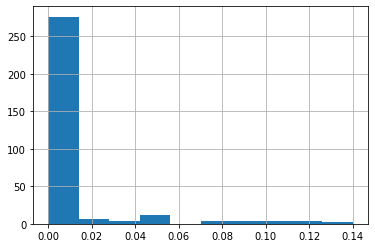

In [158]:
slice_ = hourly[(hourly.city == "Cairo") & (hourly.forecast_delta == 8)]
slice_['precipitation'].hist()

<AxesSubplot:>

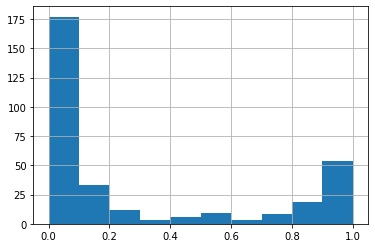

In [159]:
slice_ = hourly[(hourly.city == "Amsterdam") & (hourly.forecast_delta == 0)]
slice_['precipitation'].hist()

In [168]:
basic_model = pm.Model()

slice_ = hourly[(hourly.city == "Porto Alegre") & (hourly.forecast_delta > 0)]
deltas = slice_['forecast_delta']
X = slice_['precipitation']
y = slice_['precipitation_actual']

with basic_model:
#     alpha = pm.Uniform('alpha', lower=0.1, upper=0.5)
# #     beta = pm.Uniform('beta', lower=0.1, upper=0.5)
    
#     predicted = pm.Beta('predicted', alpha=alpha, beta=0.5, observed=X)
#     predicted = pm.Uniform('predicted', lower=0, upper=1, observed=X)
    sd = pm.Uniform('std', lower=0, upper=1, shape=len(set(deltas)))
    
    actual = pm.Normal("actual", mu=X, sd=sd[deltas - 1], observed=y)

with basic_model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.


/Users/rchaves/.pyenv/versions/3.7.8/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


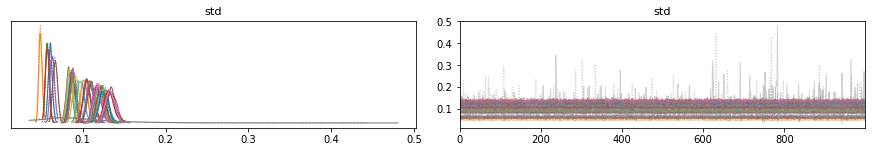

In [169]:
pm.traceplot(trace);

In [170]:
inside_range = 0
range_sizes = []
for x, delta, y_ in zip(X, deltas, y):
    std = np.mean(trace['std'].T[delta - 1])
    
    min_ = max(x - std, 0)
    max_ = min(x + std, 1)
    range_sizes.append(max_ - min_)
    if y_ >= min_ and y_ <= max_:
        inside_range += 1

print("correct", inside_range / len(X), "%")
print("range_sizes", np.mean(range_sizes))

correct 0.901144714527982 %
range_sizes 0.14892488294752027


In [ ]:
index = 93123
mu = X[index]
sigma = np.mean(trace['std'].T[deltas[index] - 1])
print("mu", mu)
print("sigma", sigma)

bins = np.array(list(range(0, 100))) / 100

line = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu)**2 / (2 * sigma**2))

plt.plot(line)

In [171]:
stds = [ trace['std'].T[d - 1].mean() for d in set(deltas) ]
stds

[0.061010094360997066,
 0.049136943018347055,
 0.05735402055371461,
 0.05745532524569865,
 0.06352718875189343,
 0.06680363016258582,
 0.08376516280956595,
 0.08394821328068647,
 0.08463541918885881,
 0.08645385559860873,
 0.08902747355813048,
 0.08777290369877608,
 0.0890130155308998,
 0.08757935484762092,
 0.08840984198603127,
 0.08774122200520636,
 0.08945826446690211,
 0.08925553613311447,
 0.09202045746280382,
 0.0979023640366891,
 0.1048069375726853,
 0.10186626550797218,
 0.10955235335484229,
 0.10540769269206317,
 0.10908746263552202,
 0.11053372619588259,
 0.11856245582390847,
 0.11991611028538374,
 0.12164250513389377,
 0.12187858124027175,
 0.1230849546748919,
 0.12322610717944199,
 0.11963829925356821,
 0.11802795845521494,
 0.11710699718236321,
 0.12260171000008971,
 0.11894572666294644,
 0.12496477143717434,
 0.12553650514513237,
 0.12641559652659815,
 0.1257861276049466,
 0.13240157799702684,
 0.13277668076575314,
 0.1317487110660167,
 0.13548712843939412,
 0.13459017929